# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.stats import gmean
from typing import Union, Optional

null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1397
after merge with benchmark dates 1397
Original number of rows: 1397
Number of rows after aggregation: 967


In [3]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
# df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark, anchor_difficulty, anchor_slope)
anchor_mode = "benchmark" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.177630
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.311554

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 3.4077e+01, final cost 2.4357e+00, first-order optimality 1.37e-04.


# OLS approach

In [4]:
df_cap = df_cm1.copy(deep=True)

# load in data from the pcd
# pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/notable_systems.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
pcd_dataset = pd.read_csv("data/all_ai_models_20250908.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
columns = {"Training compute (FLOP)": "compute", "Parameters": "parameters", "Training dataset size (datapoints)": "data"}
pcd_dataset = pcd_dataset.rename(columns=columns)

df_cap = df_cap.merge(pcd_dataset, on="Model")
# df_cap.columns

df = df_cap.copy()

print("=" * 70)
print("SIMPLE OLS APPROACH: CAPABILITY ~ LOG(COMPUTE) + TIME")
print("=" * 70)

# Prepare data for OLS
models_with_compute = df[df['compute'].notna()].copy()
print(f"Using {len(models_with_compute)} models with compute data")

# Create variables
models_with_compute['log10_compute'] = np.log10(models_with_compute['compute'])
models_with_compute['time_numeric'] = pd.to_datetime(models_with_compute['date']).dt.year + pd.to_datetime(models_with_compute['date']).dt.dayofyear / 365.25 - 2019

# Check data ranges
print(f"\nData ranges:")
print(f"  Capability: {models_with_compute['estimated_capability'].min():.3f} to {models_with_compute['estimated_capability'].max():.3f}")
print(f"  Log10(compute): {models_with_compute['log10_compute'].min():.1f} to {models_with_compute['log10_compute'].max():.1f}")
print(f"  Time: {models_with_compute['time_numeric'].min():.2f} to {models_with_compute['time_numeric'].max():.2f}")

# Fit OLS regression: C = β₀ + β₁ * log10(compute) + β₂ * time + ε
X = models_with_compute[['log10_compute', 'time_numeric']]
X = sm.add_constant(X)  # Add intercept
y = models_with_compute['estimated_capability']

model_ols = sm.OLS(y, X).fit()

print(f"\n" + "="*50)
print(f"OLS REGRESSION RESULTS")
print(f"="*50)
print(model_ols.summary())

# Extract coefficients
beta_const = model_ols.params['const']
beta_compute = model_ols.params['log10_compute'] 
beta_time = model_ols.params['time_numeric']

print(f"\nInterpretation of coefficients:")
print(f"  β₀ (constant): {beta_const:.4f}")
print(f"  β₁ (log10 compute): {beta_compute:.4f}")
print(f"  β₂ (time): {beta_time:.4f}")

print(f"\nWhat this means:")
print(f"  • 10× more compute → +{beta_compute:.3f} capability units")
print(f"  • Each year → +{beta_time:.3f} capability units (algorithmic progress)")
print(f"  • Model R² = {model_ols.rsquared:.3f}")

# Convert time coefficient to compute equivalence
# If time gives β₂ capability per year, and compute gives β₁ capability per log10 unit,
# then β₂/β₁ log10 units of compute = 1 year of algorithmic progress
# This means 10^(β₂/β₁) times more compute needed per year to match algorithmic progress

if beta_compute != 0:
    compute_equivalent_ratio = beta_time / beta_compute
    compute_multiplier_per_year = 10 ** compute_equivalent_ratio
    compute_reduction_per_year = 1 / compute_multiplier_per_year
    
    print(f"\nAlgorithmic Progress vs Compute Scaling:")
    print(f"  • 1 year of algorithmic progress = {compute_equivalent_ratio:.2f} log10 units of compute")
    print(f"  • 1 year of algorithmic progress = {compute_multiplier_per_year:.1f}× more compute")
    print(f"  • Equivalently: Each year, need {compute_reduction_per_year:.3f}× the compute for same capability")
    print(f"  • Annual compute efficiency improvement: {1/compute_reduction_per_year:.2f}×")

# Check model assumptions and diagnostics
residuals = model_ols.resid
print(f"\nModel Diagnostics:")
print(f"  • Residual std: {np.std(residuals):.3f}")
print(f"  • Mean absolute error: {np.mean(np.abs(residuals)):.3f}")

# Check for multicollinearity
correlation = models_with_compute[['log10_compute', 'time_numeric']].corr()
print(f"  • Correlation(log10_compute, time): {correlation.loc['log10_compute', 'time_numeric']:.3f}")

if abs(correlation.loc['log10_compute', 'time_numeric']) > 0.7:
    print(f"  ⚠ High correlation between compute and time - coefficients may be unstable")
elif abs(correlation.loc['log10_compute', 'time_numeric']) < 0.3:
    print(f"  ✓ Low correlation - good separation between compute scaling and time effects")
else:
    print(f"  ≈ Moderate correlation - results interpretable but not perfectly separated")

SIMPLE OLS APPROACH: CAPABILITY ~ LOG(COMPUTE) + TIME
Using 88 models with compute data

Data ranges:
  Capability: 0.185 to 2.418
  Log10(compute): 21.1 to 26.7
  Time: 0.85 to 6.52

OLS REGRESSION RESULTS
                             OLS Regression Results                             
Dep. Variable:     estimated_capability   R-squared:                       0.842
Model:                              OLS   Adj. R-squared:                  0.838
Method:                   Least Squares   F-statistic:                     226.5
Date:                  Mon, 29 Sep 2025   Prob (F-statistic):           8.74e-35
Time:                          15:17:54   Log-Likelihood:                 22.295
No. Observations:                    88   AIC:                            -38.59
Df Residuals:                        85   BIC:                            -31.16
Df Model:                             2                                         
Covariance Type:              nonrobust                         

In [5]:
# Extract frontier models - models that were top-N at their release date
# This follows the same logic as analyze_forecasting.py

def prepare_model_data(df_capabilities):
    """Prepare model data with dates for frontier analysis"""
    df = df_capabilities.copy()
    
    # If date column is string, convert to datetime
    if 'date' in df.columns and df['date'].dtype == 'object':
        df['date_obj'] = pd.to_datetime(df['date'])
    elif 'date' in df.columns:
        df['date_obj'] = df['date']
    else:
        # If no date column, try to get from other sources or skip
        print("Warning: No date column found in capabilities data")
        return df
    
    # Remove rows with missing dates or capabilities
    df = df.dropna(subset=['date_obj', 'estimated_capability'])
    
    return df

def identify_frontier_models(df_capabilities, top_n_models=1):
    """
    Identify frontier models: those that were among top N when they were released.
    
    Args:
        df_capabilities: DataFrame with model capabilities and dates
        top_n_models: Number of top models to consider as frontier (default: 1 for pure frontier)
        
    Returns:
        DataFrame containing only frontier models
    """
    df = prepare_model_data(df_capabilities)
    
    # Identify frontier models: those that were among top N when they were released
    frontier_models = []
    
    for _, model_row in df.iterrows():
        model_release_date = model_row['date_obj']
        model_capability = model_row['estimated_capability']
        
        # Find all models that existed at or before this model's release date
        available_models = df[df['date_obj'] <= model_release_date]
        
        # Check if this model was among the top N at its release time
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')
        
        if model_row['model'] in top_models_at_release['model'].values:
            frontier_models.append(model_row)
    
    # Convert to DataFrame
    df_frontier = pd.DataFrame(frontier_models)
    
    return df_frontier

# Apply frontier model selection to our fitted capabilities
print("Identifying frontier models...")
df_frontier = identify_frontier_models(df_cm1, top_n_models=1)

print(f"Found {len(df_frontier)} frontier model data points (from {len(df_cm1)} total)")
print(f"Frontier models: {', '.join(df_frontier.nsmallest(10, 'date_obj')['model'].tolist() if len(df_frontier) > 0 else [])}")

# Display frontier models
df_frontier[['model', 'date', 'estimated_capability']].sort_values('date')

Identifying frontier models...
Found 18 frontier model data points (from 149 total)
Frontier models: gpt2-xl, gpt-j-6b, Gopher (280B), GLaM (MoE), Megatron-Turing NLG 530B, text-davinci-002, gpt-4-0613, Mixtral-8x7B-v0.1, claude-3-opus-20240229, gpt-4-turbo-2024-04-09


,model,date,estimated_capability
39,gpt2-xl,2019-11-05,0.185229
48,gpt-j-6b,2021-08-05,0.507909
53,Gopher (280B),2021-12-08,1.021678
57,GLaM (MoE),2021-12-13,1.142936
141,Megatron-Turing NLG 530B,2022-01-28,1.150129
41,text-davinci-002,2022-03-15,1.443883
56,gpt-4-0613,2023-06-13,1.467350
139,Mixtral-8x7B-v0.1,2023-12-11,1.550895
83,claude-3-opus-20240229,2024-02-29,1.614018
92,gpt-4-turbo-2024-04-09,2024-04-09,1.659871


In [6]:
# df_cap = df_cm1.copy(deep=True)
df_cap = df_frontier.copy(deep=True)
cutoff_date = '2021-01-01'
df_cap = df_cap[df_cap["date_obj"] > pd.to_datetime(cutoff_date)]

# load in data from the pcd
# pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/notable_systems.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
pcd_dataset = pd.read_csv("data/all_ai_models_20250908.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
columns = {"Training compute (FLOP)": "compute", "Parameters": "parameters", "Training dataset size (datapoints)": "data"}
pcd_dataset = pcd_dataset.rename(columns=columns)

df_cap = df_cap.merge(pcd_dataset, on="Model")
df = df_cap.copy()
# df

In [7]:
## The Simplest Possible Approach: OLS Regression

# Let's try the most straightforward approach:
# C_m = β₀ + β₁ * log₁₀(F_m) + β₂ * time + ε

import statsmodels.api as sm

print("=" * 70)
print("SIMPLE OLS APPROACH: CAPABILITY ~ LOG(COMPUTE) + TIME")
print("=" * 70)

# Prepare data for OLS
models_with_compute = df[df['compute'].notna()].copy()
print(f"Using {len(models_with_compute)} models with compute data")

# Create variables
models_with_compute['log10_compute'] = np.log10(models_with_compute['compute'])
models_with_compute['time_numeric'] = pd.to_datetime(models_with_compute['date']).dt.year + pd.to_datetime(models_with_compute['date']).dt.dayofyear / 365.25 - 2019

# Check data ranges
print(f"\nData ranges:")
print(f"  Capability: {models_with_compute['estimated_capability'].min():.3f} to {models_with_compute['estimated_capability'].max():.3f}")
print(f"  Log10(compute): {models_with_compute['log10_compute'].min():.1f} to {models_with_compute['log10_compute'].max():.1f}")
print(f"  Time: {models_with_compute['time_numeric'].min():.2f} to {models_with_compute['time_numeric'].max():.2f}")

# Fit OLS regression: C = β₀ + β₁ * log10(compute) + β₂ * time + ε
X = models_with_compute[['log10_compute', 'time_numeric']]
X = sm.add_constant(X)  # Add intercept
y = models_with_compute['estimated_capability']

model_ols = sm.OLS(y, X).fit()

print(f"\n" + "="*50)
print(f"OLS REGRESSION RESULTS")
print(f"="*50)
print(model_ols.summary())

# Extract coefficients
beta_const = model_ols.params['const']
beta_compute = model_ols.params['log10_compute'] 
beta_time = model_ols.params['time_numeric']

print(f"\nInterpretation of coefficients:")
print(f"  β₀ (constant): {beta_const:.4f}")
print(f"  β₁ (log10 compute): {beta_compute:.4f}")
print(f"  β₂ (time): {beta_time:.4f}")

print(f"\nWhat this means:")
print(f"  • 10× more compute → +{beta_compute:.3f} capability units")
print(f"  • Each year → +{beta_time:.3f} capability units (algorithmic progress)")
print(f"  • Model R² = {model_ols.rsquared:.3f}")

# Convert time coefficient to compute equivalence
# If time gives β₂ capability per year, and compute gives β₁ capability per log10 unit,
# then β₂/β₁ log10 units of compute = 1 year of algorithmic progress
# This means 10^(β₂/β₁) times more compute needed per year to match algorithmic progress

if beta_compute != 0:
    compute_equivalent_ratio = beta_time / beta_compute
    compute_multiplier_per_year = 10 ** compute_equivalent_ratio
    compute_reduction_per_year = 1 / compute_multiplier_per_year
    
    print(f"\nAlgorithmic Progress vs Compute Scaling:")
    print(f"  • 1 year of algorithmic progress = {compute_equivalent_ratio:.2f} log10 units of compute")
    print(f"  • 1 year of algorithmic progress = {compute_multiplier_per_year:.1f}× more compute")
    print(f"  • Equivalently: Each year, need {compute_reduction_per_year:.3f}× the compute for same capability")
    print(f"  • Annual compute efficiency improvement: {1/compute_reduction_per_year:.2f}×")

# Check model assumptions and diagnostics
residuals = model_ols.resid
print(f"\nModel Diagnostics:")
print(f"  • Residual std: {np.std(residuals):.3f}")
print(f"  • Mean absolute error: {np.mean(np.abs(residuals)):.3f}")

# Check for multicollinearity
correlation = models_with_compute[['log10_compute', 'time_numeric']].corr()
print(f"  • Correlation(log10_compute, time): {correlation.loc['log10_compute', 'time_numeric']:.3f}")

if abs(correlation.loc['log10_compute', 'time_numeric']) > 0.7:
    print(f"  ⚠ High correlation between compute and time - coefficients may be unstable")
elif abs(correlation.loc['log10_compute', 'time_numeric']) < 0.3:
    print(f"  ✓ Low correlation - good separation between compute scaling and time effects")
else:
    print(f"  ≈ Moderate correlation - results interpretable but not perfectly separated")

SIMPLE OLS APPROACH: CAPABILITY ~ LOG(COMPUTE) + TIME
Using 11 models with compute data

Data ranges:
  Capability: 0.508 to 1.882
  Log10(compute): 22.2 to 25.6
  Time: 2.59 to 5.56

OLS REGRESSION RESULTS
                             OLS Regression Results                             
Dep. Variable:     estimated_capability   R-squared:                       0.870
Model:                              OLS   Adj. R-squared:                  0.837
Method:                   Least Squares   F-statistic:                     26.76
Date:                  Mon, 29 Sep 2025   Prob (F-statistic):           0.000286
Time:                          15:17:54   Log-Likelihood:                 6.3570
No. Observations:                    11   AIC:                            -6.714
Df Residuals:                         8   BIC:                            -5.520
Df Model:                             2                                         
Covariance Type:              nonrobust                         

# Family approach

In [8]:
df_cap = df_cm1.copy(deep=True)

# load in data from the pcd
# pcd_dataset = pd.read_csv("https://epochai.org/data/epochdb/notable_systems.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
pcd_dataset = pd.read_csv("data/all_ai_models_20250908.csv")[["Model", "Training compute (FLOP)", "Parameters", "Training dataset size (datapoints)"]]
columns = {"Training compute (FLOP)": "compute", "Parameters": "parameters", "Training dataset size (datapoints)": "data"}
pcd_dataset = pcd_dataset.rename(columns=columns)

df_cap = df_cap.merge(pcd_dataset, on="Model")
# df_cap.columns

df = df_cap.copy()

In [9]:
df[df["model"].str.contains("Llama-4")]

,model_id,estimated_capability,model,is_anchor,Model,date,date_obj,compute,parameters,data
42,m56,1.893877,Llama-4-Maverick-17B-128E-Instruct-FP8,False,Llama 4 Maverick,2025-04-05,2025-04-05,2.244000e+24,4.000000e+11,3.000000e+13
53,m57,1.765576,Llama-4-Scout-17B-16E-Instruct,False,Llama 4 Scout,2025-04-05,2025-04-05,4.080000e+24,1.090000e+11,3.000000e+13
68,m84,1.633024,Llama-4-Maverick-17B-128E-Instruct,False,Llama 4 Maverick,2025-04-05,2025-04-05,2.244000e+24,4.000000e+11,3.000000e+13


In [15]:
mistral_family = [
    'mistral-large-2407',
    'mistral-large-2411',
    'mistral-medium-2505',
    # 'Mistral-7B-v0.1',
    # 'Mixtral-8x7B-v0.1',
]

qwen_family = [
    # 'qwen-max-2025-01-25',
    'qwen2.5-72b-instruct',
    # 'qwen3-235b-a22b',
    # 'Qwen-14B',
    # 'Qwen-7B',
    'Qwen2.5-72B',
    'Qwen2.5-Coder-1.5B',
    'Qwen2.5-Coder-32B',
    'Qwen2.5-Coder-7B',
    'Qwen2.5-VL-72B-Instruct',
]

phi_family = [
    'Phi-3-medium-128k-instruct',
    # 'Phi-3-mini-4k-instruct',
    'Phi-3-small-8k-instruct',
    # 'phi-1_5',
    # 'phi-2',
    # 'phi-4',
]

# grok_family = [
#     # 'grok-2-1212',
#     'grok-3-beta',
#     # 'grok-3-mini-beta_high',
#     # 'grok-3-mini-beta_low',
#     # 'grok-4-0709',
# ]

gpt4_1_family = [
    # 'text-davinci-001',
    # 'text-davinci-002',
    # 'gpt-3.5-turbo-0613',
    # 'gpt-3.5-turbo-1106',
    # 'gpt-4-0613',
    # 'gpt-4-turbo-2024-04-09',
    'gpt-4.1-2025-04-14',
    # 'gpt-4.1-mini-2025-04-14',
    # 'gpt-4.1-nano-2025-04-14',
    # 'gpt-4.5-preview-2025-02-27',
    # 'gpt2-xl',
    'o4-mini-2025-04-16_high',
    'o4-mini-2025-04-16_medium',
]

gpt4o_family = [
    'gpt-4o-2024-05-13',
    'gpt-4o-2024-08-06',
    'gpt-4o-2024-11-20',
    # 'gpt-4o-mini-2024-07-18',
    'o1-2024-12-17_high',
    'o1-2024-12-17_medium',
    # 'o1-mini-2024-09-12_high',
    # 'o1-mini-2024-09-12_medium',
    'o1-preview-2024-09-12',
    'o3-2025-04-16_high',
    'o3-2025-04-16_medium',
    # 'o3-mini-2025-01-31_high',
    # 'o3-mini-2025-01-31_medium',
]

# deepseek_family = [
#     'DeepSeek-R1',
#     'DeepSeek-R1-0528',
#     'DeepSeek-V2',
#     'DeepSeek-V3',
#     'DeepSeek-V3-0324',
# ]

llama_family = [
    'LLaMA-13B',
    'LLaMA-33B',
    'LLaMA-65B',
    'LLaMA-7B',
    # 'Llama-3.2-90B-Vision-Instruct',
    # 'Llama-3.3-70B-Instruct',
    # 'Meta-Llama-3-70B-Instruct',
    # 'Meta-Llama-3-8B-Instruct',
]

llama2_family = [
    'Llama-2-13b',
    'Llama-2-34b',
    'Llama-2-70b-hf ',
    'Llama-2-7b',
]

llama3_1_family = [
    'Llama-3.1-405B',
    'Llama-3.1-405B-Instruct',
    'Llama-3.1-70B-Instruct',
    'Llama-3.1-8B-Instruct',
]

llama4_family = [
    'Llama-4-Maverick-17B-128E-Instruct',
    'Llama-4-Maverick-17B-128E-Instruct-FP8',
    'Llama-4-Scout-17B-16E-Instruct',
]


claude_family = [
    # 'claude-2.0',
    # 'claude-3-5-haiku-20241022',
    # 'claude-3-5-sonnet-20240620',
    # 'claude-3-5-sonnet-20241022',
    # 'claude-3-7-sonnet-20250219',
    # 'claude-3-7-sonnet-20250219_16K',
    # 'claude-3-7-sonnet-20250219_32K',
    # 'claude-3-7-sonnet-20250219_64K',
    'claude-3-haiku-20240307',
    'claude-3-opus-20240229',
    'claude-3-sonnet-20240229',
    # 'claude-opus-4-1-20250805',
    # 'claude-opus-4-20250514',
    # 'claude-opus-4-20250514_16K',
    # 'claude-sonnet-4-20250514',
    # 'claude-sonnet-4-20250514_16K',
    # 'claude-sonnet-4-20250514_32K'
]

# gemini_family = [
#     'gemini-1.5-flash-001',
#     'gemini-1.5-flash-002',
#     'gemini-1.5-pro-001',
#     'gemini-1.5-pro-002',
#     'gemini-2.0-flash-001',
#     'gemini-2.0-flash-thinking-exp-01-21',
#     'gemini-2.0-pro-exp-02-05',
#     'gemini-2.5-flash-preview-04-17',
#     'gemini-2.5-flash-preview-05-20',
#     'gemini-2.5-pro-exp-03-25',
#     'gemini-2.5-pro-preview-03-25',
#     'gemini-2.5-pro-preview-05-06',
#     'gemini-2.5-pro-preview-06-05',
# ]

# gemma_family = [
#     # 'gemma-2-27b-it',
#     # 'gemma-2-9b-it',
#     # 'gemma-2b',
#     # 'gemma-3-27b-it',
#     # 'gemma-7b',
# ]

In [16]:
min_models = 3

all_families = {
    'Mistral': mistral_family,
    'Qwen': qwen_family,
    'Phi': phi_family,
    # 'Grok': grok_family,
    'GPT-4.1': gpt4_1_family,
    'GPT-4o': gpt4o_family,
    # 'DeepSeek': deepseek_family,
    'LLaMA': llama_family,
    'LLaMA 2': llama2_family,
    'LLaMA 3.1': llama3_1_family,
    # 'LLaMA 4': llama4_family,
    'Claude': claude_family,
    # 'Gemini': gemini_family,
    # 'Gemma': gemma_family,
}

# Check which families have sufficient data (>= 2 models with compute data)
valid_families = {}
family_stats = {}
for family_name, family_models in all_families.items():
    family_data = df[df['model'].isin(family_models) & df['compute'].notna()]
    if len(family_data) >= min_models:
        valid_families[family_name] = family_models
        family_stats[family_name] = {
            'count': len(family_data),
            'models': family_data['model'].tolist(),
            'compute_range': (family_data['compute'].min(), family_data['compute'].max()),
            'capability_range': (family_data['estimated_capability'].min(), family_data['estimated_capability'].max())
        }

print(f"Valid families with >= {min_models} models having compute data:")
for family_name, stats in family_stats.items():
    print(f"\n{family_name}: {stats['count']} models")
    print(f"  Models: {stats['models']}")
    print(f"  Compute range: {stats['compute_range'][0]:.2e} - {stats['compute_range'][1]:.2e} FLOPs")
    print(f"  Capability range: {stats['capability_range'][0]:.3f} - {stats['capability_range'][1]:.3f}")

print(f"\nTotal valid families: {len(valid_families)}")

Valid families with >= 3 models having compute data:

Qwen: 6 models
  Models: ['qwen2.5-72b-instruct', 'Qwen2.5-VL-72B-Instruct', 'Qwen2.5-72B', 'Qwen2.5-Coder-32B', 'Qwen2.5-Coder-7B', 'Qwen2.5-Coder-1.5B']
  Compute range: 5.08e+22 - 7.80e+24 FLOPs
  Capability range: 0.744 - 1.765

GPT-4o: 3 models
  Models: ['gpt-4o-2024-11-20', 'gpt-4o-2024-08-06', 'gpt-4o-2024-05-13']
  Compute range: 3.81e+25 - 3.81e+25 FLOPs
  Capability range: 1.696 - 1.709

LLaMA: 4 models
  Models: ['LLaMA-65B', 'LLaMA-33B', 'LLaMA-13B', 'LLaMA-7B']
  Compute range: 4.00e+22 - 5.50e+23 FLOPs
  Capability range: 0.784 - 1.205

LLaMA 2: 4 models
  Models: ['Llama-2-70b-hf ', 'Llama-2-13b', 'Llama-2-34b', 'Llama-2-7b']
  Compute range: 8.40e+22 - 8.10e+23 FLOPs
  Capability range: 0.850 - 1.335

LLaMA 3.1: 4 models
  Models: ['Llama-3.1-405B', 'Llama-3.1-405B-Instruct', 'Llama-3.1-70B-Instruct', 'Llama-3.1-8B-Instruct']
  Compute range: 1.22e+24 - 3.80e+25 FLOPs
  Capability range: 1.398 - 1.882

Total valid f

ALL-MODELS APPROACH: ALGORITHMIC PROGRESS ANALYSIS

STAGE 1: Estimate k from all models (pooled)

Fitting all 88 models:
  • Estimated k: 0.1584 ± 0.0095 (R² = 0.763)
  • p-value: 1.223e-28

>>> USING k = 0.1584 for Stage 2 <<<


STAGE 2: Fit b values over time with k from all models

Using 88 models with compute data
Date range: 2019-11-05 to 2025-07-09

Temporal trend in b:
  db/dt = 0.1009 ± 0.0212 per year
  R² = 0.208
  p-value = 7.943e-06

Algorithmic Progress Interpretation:
  • Annual efficiency improvement: 1.89×
  • Halving time (2× efficiency): 1.09 years
  • Each year, need 0.529× the compute for same capability
  • Equivalently: Same compute gives 1.89× better capability/year


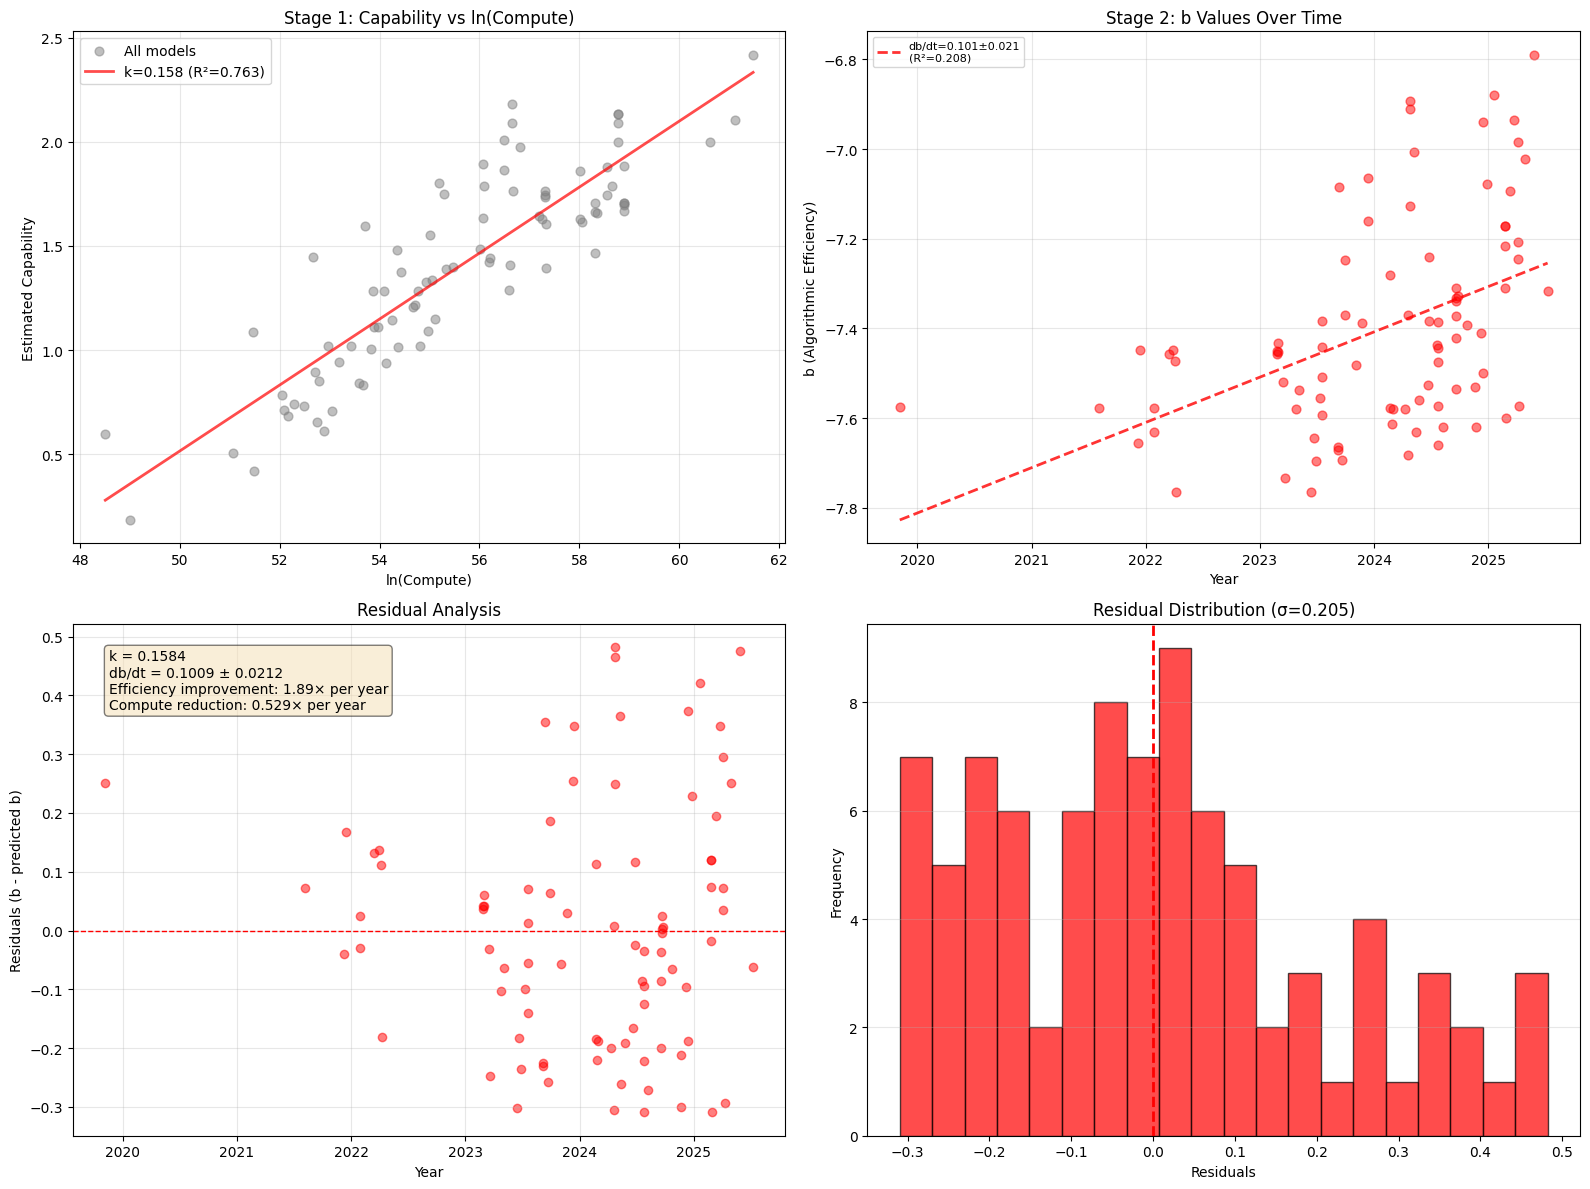


ANALYSIS COMPLETE


In [18]:
print("=" * 70)
print("ALL-MODELS APPROACH: ALGORITHMIC PROGRESS ANALYSIS")  
print("=" * 70)
print("\nSTAGE 1: Estimate k from all models (pooled)")
print("=" * 70)

# Fit k by regressing all models' capabilities vs log(compute)
all_models_compute_alt = df[df['compute'].notna()].copy()
all_models_compute_alt['log_compute'] = np.log(all_models_compute_alt['compute'])
all_models_compute_alt['date_numeric'] = (
    pd.to_datetime(all_models_compute_alt['date']).dt.year + 
    pd.to_datetime(all_models_compute_alt['date']).dt.dayofyear / 365.25
)

# Simple linear regression: C = k * ln(F) + constant
slope_k_all, intercept_all, r_value_all, p_value_all, std_err_all = linregress(
    all_models_compute_alt['log_compute'], 
    all_models_compute_alt['estimated_capability']
)

print(f"\nFitting all {len(all_models_compute_alt)} models:")
print(f"  • Estimated k: {slope_k_all:.4f} ± {std_err_all:.4f} (R² = {r_value_all**2:.3f})")
print(f"  • p-value: {p_value_all:.3e}")

# Use this k for Stage 2
k_all_models = slope_k_all
print(f"\n>>> USING k = {k_all_models:.4f} for Stage 2 <<<")


print("\n\n" + "=" * 70)
print("STAGE 2: Fit b values over time with k from all models")
print("=" * 70)

# Calculate b values using the all-models k
all_models_compute_alt['b'] = (
    all_models_compute_alt['estimated_capability'] - 
    k_all_models * all_models_compute_alt['log_compute']
)

print(f"\nUsing {len(all_models_compute_alt)} models with compute data")
print(f"Date range: {all_models_compute_alt['date'].min()} to {all_models_compute_alt['date'].max()}")

# Fit temporal trend in b
b_slope_alt, b_intercept_alt, b_r_value_alt, b_p_value_alt, b_std_err_alt = linregress(
    all_models_compute_alt['date_numeric'], 
    all_models_compute_alt['b']
)

print(f"\nTemporal trend in b:")
print(f"  db/dt = {b_slope_alt:.4f} ± {b_std_err_alt:.4f} per year")
print(f"  R² = {b_r_value_alt**2:.3f}")
print(f"  p-value = {b_p_value_alt:.3e}")

# Convert to algorithmic progress rate
compute_ratio_per_year_alt = np.exp(-b_slope_alt / k_all_models)
efficiency_improvement_per_year_alt = 1 / compute_ratio_per_year_alt

print(f"\nAlgorithmic Progress Interpretation:")
print(f"  • Annual efficiency improvement: {efficiency_improvement_per_year_alt:.2f}×")
print(f"  • Halving time (2× efficiency): {np.log(2) / np.log(efficiency_improvement_per_year_alt):.2f} years")
if efficiency_improvement_per_year_alt > 1:
    print(f"  • Each year, need {compute_ratio_per_year_alt:.3f}× the compute for same capability")
    print(f"  • Equivalently: Same compute gives {efficiency_improvement_per_year_alt:.2f}× better capability/year")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Capabilities vs log(compute)
ax1 = axes[0, 0]

# Plot all data points
ax1.scatter(all_models_compute_alt['log_compute'], 
           all_models_compute_alt['estimated_capability'],
           alpha=0.5, s=40, c='gray', label='All models')

# Add trend line
log_compute_range = np.linspace(
    all_models_compute_alt['log_compute'].min(),
    all_models_compute_alt['log_compute'].max(),
    100
)

# All-models k line
capability_line_all = k_all_models * log_compute_range + intercept_all
ax1.plot(log_compute_range, capability_line_all, 'r-', linewidth=2, 
        alpha=0.7, label=f'k={k_all_models:.3f} (R²={r_value_all**2:.3f})')

ax1.set_xlabel('ln(Compute)')
ax1.set_ylabel('Estimated Capability')
ax1.set_title('Stage 1: Capability vs ln(Compute)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: b values over time
ax2 = axes[0, 1]

# Plot b values
ax2.scatter(all_models_compute_alt['date_numeric'], 
           all_models_compute_alt['b'],
           alpha=0.5, s=40, color='red')

# Add temporal trend line
time_range = np.linspace(
    all_models_compute_alt['date_numeric'].min(),
    all_models_compute_alt['date_numeric'].max(),
    100
)

# All-models trend
b_trend_all = b_slope_alt * time_range + b_intercept_alt
ax2.plot(time_range, b_trend_all, 'r--', linewidth=2, alpha=0.8,
        label=f'db/dt={b_slope_alt:.3f}±{b_std_err_alt:.3f}\n(R²={b_r_value_alt**2:.3f})')

ax2.set_xlabel('Year')
ax2.set_ylabel('b (Algorithmic Efficiency)')
ax2.set_title('Stage 2: b Values Over Time')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals
ax3 = axes[1, 0]
predicted_b_all = b_slope_alt * all_models_compute_alt['date_numeric'] + b_intercept_alt
residuals_all = all_models_compute_alt['b'] - predicted_b_all

ax3.scatter(all_models_compute_alt['date_numeric'], residuals_all, alpha=0.5, color='red')
ax3.axhline(0, color='red', linestyle='--', linewidth=1)
ax3.set_xlabel('Year')
ax3.set_ylabel('Residuals (b - predicted b)')
ax3.set_title('Residual Analysis')
ax3.grid(True, alpha=0.3)

# Add text with key results
textstr = f'k = {k_all_models:.4f}\ndb/dt = {b_slope_alt:.4f} ± {b_std_err_alt:.4f}\n'
textstr += f'Efficiency improvement: {efficiency_improvement_per_year_alt:.2f}× per year\n'
textstr += f'Compute reduction: {compute_ratio_per_year_alt:.3f}× per year'
ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 4: Histogram of residuals
ax4 = axes[1, 1]
ax4.hist(residuals_all, bins=20, alpha=0.7, color='red', edgecolor='black')
ax4.axvline(0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Residual Distribution (σ={np.std(residuals_all):.3f})')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)


TWO-STAGE APPROACH: ALGORITHMIC PROGRESS ANALYSIS

STAGE 1: Estimate k values per family (without temporal analysis)
Mistral: Insufficient data (2 models with compute)

Qwen Family:
  • Models: 6 (2024-09-18 to 2024-09-19)
  • Estimated k: 0.1957 ± 0.0053 (R² = 0.997)
    2024-09-18 Qwen2.5-Coder-32B              C=1.390 F=1.07e+24
    2024-09-18 Qwen2.5-Coder-7B               C=1.111 F=2.51e+23
    2024-09-18 Qwen2.5-Coder-1.5B             C=0.744 F=5.08e+22
    2024-09-19 qwen2.5-72b-instruct           C=1.765 F=7.80e+24
    2024-09-19 Qwen2.5-VL-72B-Instruct        C=1.744 F=7.80e+24
    2024-09-19 Qwen2.5-72B                    C=1.737 F=7.80e+24
Phi: Insufficient data (2 models with compute)
GPT-4o: Insufficient compute variation (all models have same compute)

LLaMA Family:
  • Models: 4 (2023-02-24 to 2023-02-27)
  • Estimated k: 0.1630 ± 0.0055 (R² = 0.998)
    2023-02-24 LLaMA-65B                      C=1.205 F=5.50e+23
    2023-02-24 LLaMA-7B                       C=0.784 F=4

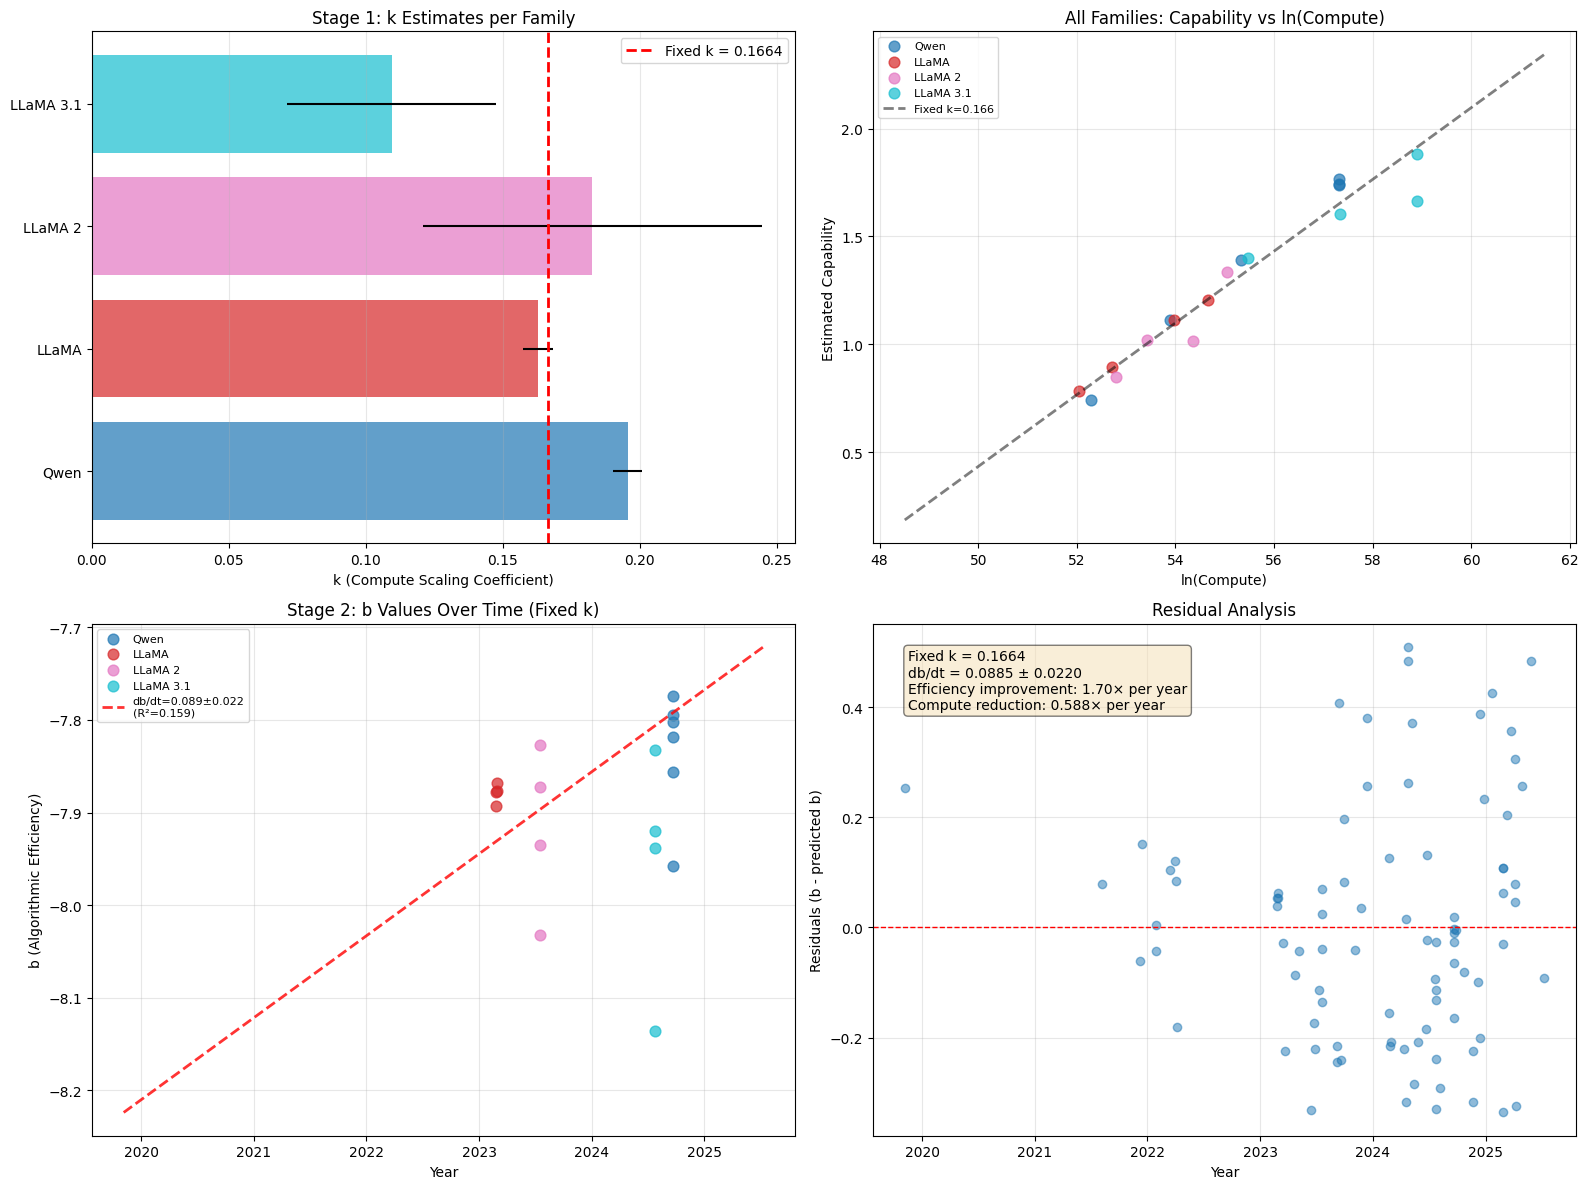


ANALYSIS COMPLETE


In [19]:
print("=" * 70)
print("TWO-STAGE APPROACH: ALGORITHMIC PROGRESS ANALYSIS")  
print("=" * 70)
print("\nSTAGE 1: Estimate k values per family (without temporal analysis)")
print("=" * 70)

# Step 1: For each family with sufficient data, estimate k only
family_k_estimates = {}

for family_name, family_models in all_families.items():
    family_data = df[df['model'].isin(family_models) & df['compute'].notna()].copy()
    
    if len(family_data) >= min_models:
        # Sort by date to see temporal progression
        family_data = family_data.sort_values('date')
        
        log_compute = np.log(family_data['compute'])
        capabilities = family_data['estimated_capability']
        
        # Check if we have sufficient variation in compute values
        if len(log_compute.unique()) > 1:
            # Fit family-specific k (compute scaling coefficient)
            slope_k, intercept, r_value, p_value, std_err = linregress(log_compute, capabilities)
            
            family_k_estimates[family_name] = {
                'family_k': slope_k,
                'k_r_squared': r_value**2,
                'k_std_err': std_err,
                'n_models': len(family_data),
                'date_range': (family_data['date'].min(), family_data['date'].max()),
                'data': family_data,
                'intercept': intercept
            }
            
            print(f"\n{family_name} Family:")
            print(f"  • Models: {len(family_data)} ({family_data['date'].min()} to {family_data['date'].max()})")
            print(f"  • Estimated k: {slope_k:.4f} ± {std_err:.4f} (R² = {r_value**2:.3f})")
            
            # Show the models in this family
            for idx, row in family_data.iterrows():
                print(f"    {row['date']} {row['model']:30s} C={row['estimated_capability']:.3f} F={row['compute']:.2e}")
            
        else:
            print(f"{family_name}: Insufficient compute variation (all models have same compute)")
    else:
        if len(family_data) > 0:
            print(f"{family_name}: Insufficient data ({len(family_data)} models with compute)")

print(f"\n\nSummary: Successfully estimated k for {len(family_k_estimates)} families")
print("=" * 70)

# Calculate average k across families
k_values = [results['family_k'] for results in family_k_estimates.values()]
k_weights = [results['n_models'] for results in family_k_estimates.values()]  # Weight by number of models

# Simple average
k_mean_simple = np.mean(k_values)
k_std_simple = np.std(k_values)

# Weighted average (by number of models in each family)
k_mean_weighted = np.average(k_values, weights=k_weights)

print(f"\nEstimated k values across families:")
for family_name, results in family_k_estimates.items():
    print(f"  {family_name:15s}: k = {results['family_k']:.4f} (n={results['n_models']})")

print(f"\nAverage k (simple): {k_mean_simple:.4f} ± {k_std_simple:.4f}")
print(f"Average k (weighted by n): {k_mean_weighted:.4f}")

# Use the weighted average going forward
k_fixed = k_mean_weighted
print(f"\n>>> USING FIXED k = {k_fixed:.4f} for Stage 2 <<<")


print("\n\n" + "=" * 70)
print("STAGE 2: Fit b values over time with fixed k")
print("=" * 70)

# Now use fixed k to calculate b for ALL models with compute data
all_models_with_compute = df[df['compute'].notna()].copy()
all_models_with_compute['log_compute'] = np.log(all_models_with_compute['compute'])
all_models_with_compute['date_numeric'] = (
    pd.to_datetime(all_models_with_compute['date']).dt.year + 
    pd.to_datetime(all_models_with_compute['date']).dt.dayofyear / 365.25
)

# Calculate b for each model using fixed k: b = C - k * ln(F)
all_models_with_compute['b'] = (
    all_models_with_compute['estimated_capability'] - 
    k_fixed * all_models_with_compute['log_compute']
)

print(f"\nUsing {len(all_models_with_compute)} models with compute data")
print(f"Date range: {all_models_with_compute['date'].min()} to {all_models_with_compute['date'].max()}")

# Fit temporal trend in b across all models
b_slope, b_intercept, b_r_value, b_p_value, b_std_err = linregress(
    all_models_with_compute['date_numeric'], 
    all_models_with_compute['b']
)

print(f"\nTemporal trend in b:")
print(f"  db/dt = {b_slope:.4f} ± {b_std_err:.4f} per year")
print(f"  R² = {b_r_value**2:.3f}")
print(f"  p-value = {b_p_value:.3e}")

# Convert to algorithmic progress rate
# If C = k*ln(F) + b(t), and b(t) = b0 + (db/dt)*t
# Then to maintain same C, we need: k*ln(F2/F1) = -(db/dt)*Δt
# So F2/F1 = exp(-(db/dt)*Δt / k)
# For annual improvement: F_new/F_old = exp(-(db/dt) / k)

compute_ratio_per_year = np.exp(-b_slope / k_fixed)
efficiency_improvement_per_year = 1 / compute_ratio_per_year

print(f"\nAlgorithmic Progress Interpretation:")
print(f"  • Annual efficiency improvement: {efficiency_improvement_per_year:.2f}×")
print(f"  • Halving time (2× efficiency): {np.log(2) / np.log(efficiency_improvement_per_year):.2f} years")
if efficiency_improvement_per_year > 1:
    print(f"  • Each year, need {compute_ratio_per_year:.3f}× the compute for same capability")
    print(f"  • Equivalently: Same compute gives {efficiency_improvement_per_year:.2f}× better capability/year")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: k estimates per family
ax1 = axes[0, 0]
family_names = list(family_k_estimates.keys())
k_vals = [family_k_estimates[fn]['family_k'] for fn in family_names]
k_errs = [family_k_estimates[fn]['k_std_err'] for fn in family_names]
colors = plt.cm.tab10(np.linspace(0, 1, len(family_names)))

ax1.barh(family_names, k_vals, xerr=k_errs, color=colors, alpha=0.7)
ax1.axvline(k_fixed, color='red', linestyle='--', linewidth=2, label=f'Fixed k = {k_fixed:.4f}')
ax1.set_xlabel('k (Compute Scaling Coefficient)')
ax1.set_title('Stage 1: k Estimates per Family')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Capability vs log(compute) for all families
ax2 = axes[0, 1]
for i, (family_name, results) in enumerate(family_k_estimates.items()):
    family_data = results['data']
    log_compute = np.log(family_data['compute'])
    capabilities = family_data['estimated_capability']
    
    ax2.scatter(log_compute, capabilities, alpha=0.7, s=60, 
               label=family_name, color=colors[i])

# Add line with fixed k
log_compute_range = np.linspace(
    all_models_with_compute['log_compute'].min(),
    all_models_with_compute['log_compute'].max(),
    100
)
# Use median b for reference line
median_b = all_models_with_compute['b'].median()
capability_line = k_fixed * log_compute_range + median_b
ax2.plot(log_compute_range, capability_line, 'k--', linewidth=2, 
        alpha=0.5, label=f'Fixed k={k_fixed:.3f}')

ax2.set_xlabel('ln(Compute)')
ax2.set_ylabel('Estimated Capability')
ax2.set_title('All Families: Capability vs ln(Compute)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: b values over time
ax3 = axes[1, 0]
for i, (family_name, results) in enumerate(family_k_estimates.items()):
    family_data = results['data'].copy()
    family_data['log_compute'] = np.log(family_data['compute'])
    family_data['date_numeric'] = (
        pd.to_datetime(family_data['date']).dt.year + 
        pd.to_datetime(family_data['date']).dt.dayofyear / 365.25
    )
    family_data['b'] = family_data['estimated_capability'] - k_fixed * family_data['log_compute']
    
    ax3.scatter(family_data['date_numeric'], family_data['b'], 
               alpha=0.7, s=60, label=family_name, color=colors[i])

# Add temporal trend line
time_range = np.linspace(
    all_models_with_compute['date_numeric'].min(),
    all_models_with_compute['date_numeric'].max(),
    100
)
b_trend = b_slope * time_range + b_intercept
ax3.plot(time_range, b_trend, 'r--', linewidth=2, alpha=0.8,
        label=f'db/dt={b_slope:.3f}±{b_std_err:.3f}\n(R²={b_r_value**2:.3f})')

ax3.set_xlabel('Year')
ax3.set_ylabel('b (Algorithmic Efficiency)')
ax3.set_title('Stage 2: b Values Over Time (Fixed k)')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals
ax4 = axes[1, 1]
predicted_b = b_slope * all_models_with_compute['date_numeric'] + b_intercept
residuals = all_models_with_compute['b'] - predicted_b

ax4.scatter(all_models_with_compute['date_numeric'], residuals, alpha=0.5)
ax4.axhline(0, color='red', linestyle='--', linewidth=1)
ax4.set_xlabel('Year')
ax4.set_ylabel('Residuals (b - predicted b)')
ax4.set_title('Residual Analysis')
ax4.grid(True, alpha=0.3)

# Add text with key results
textstr = f'Fixed k = {k_fixed:.4f}\ndb/dt = {b_slope:.4f} ± {b_std_err:.4f}\n'
textstr += f'Efficiency improvement: {efficiency_improvement_per_year:.2f}× per year\n'
textstr += f'Compute reduction: {compute_ratio_per_year:.3f}× per year'
ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)

COMPARISON: Family-Based vs All-Models Approach

Compute Scaling Coefficient (k):
  Family-based (weighted avg): 0.1309
  All-models fit:              0.1584
  Difference:                  0.0274 (20.9%)

Algorithmic Progress Rate (db/dt):
  Family-based approach: 0.1430 ± 0.0197 per year
  All-models approach:   0.1009 ± 0.0212 per year
  Difference:            0.0421

Efficiency Improvement:
  Family-based: 2.98× per year
  All-models:   1.89× per year

Model Fit Quality (R² for temporal trend):
  Family-based: 0.3811
  All-models:   0.2081


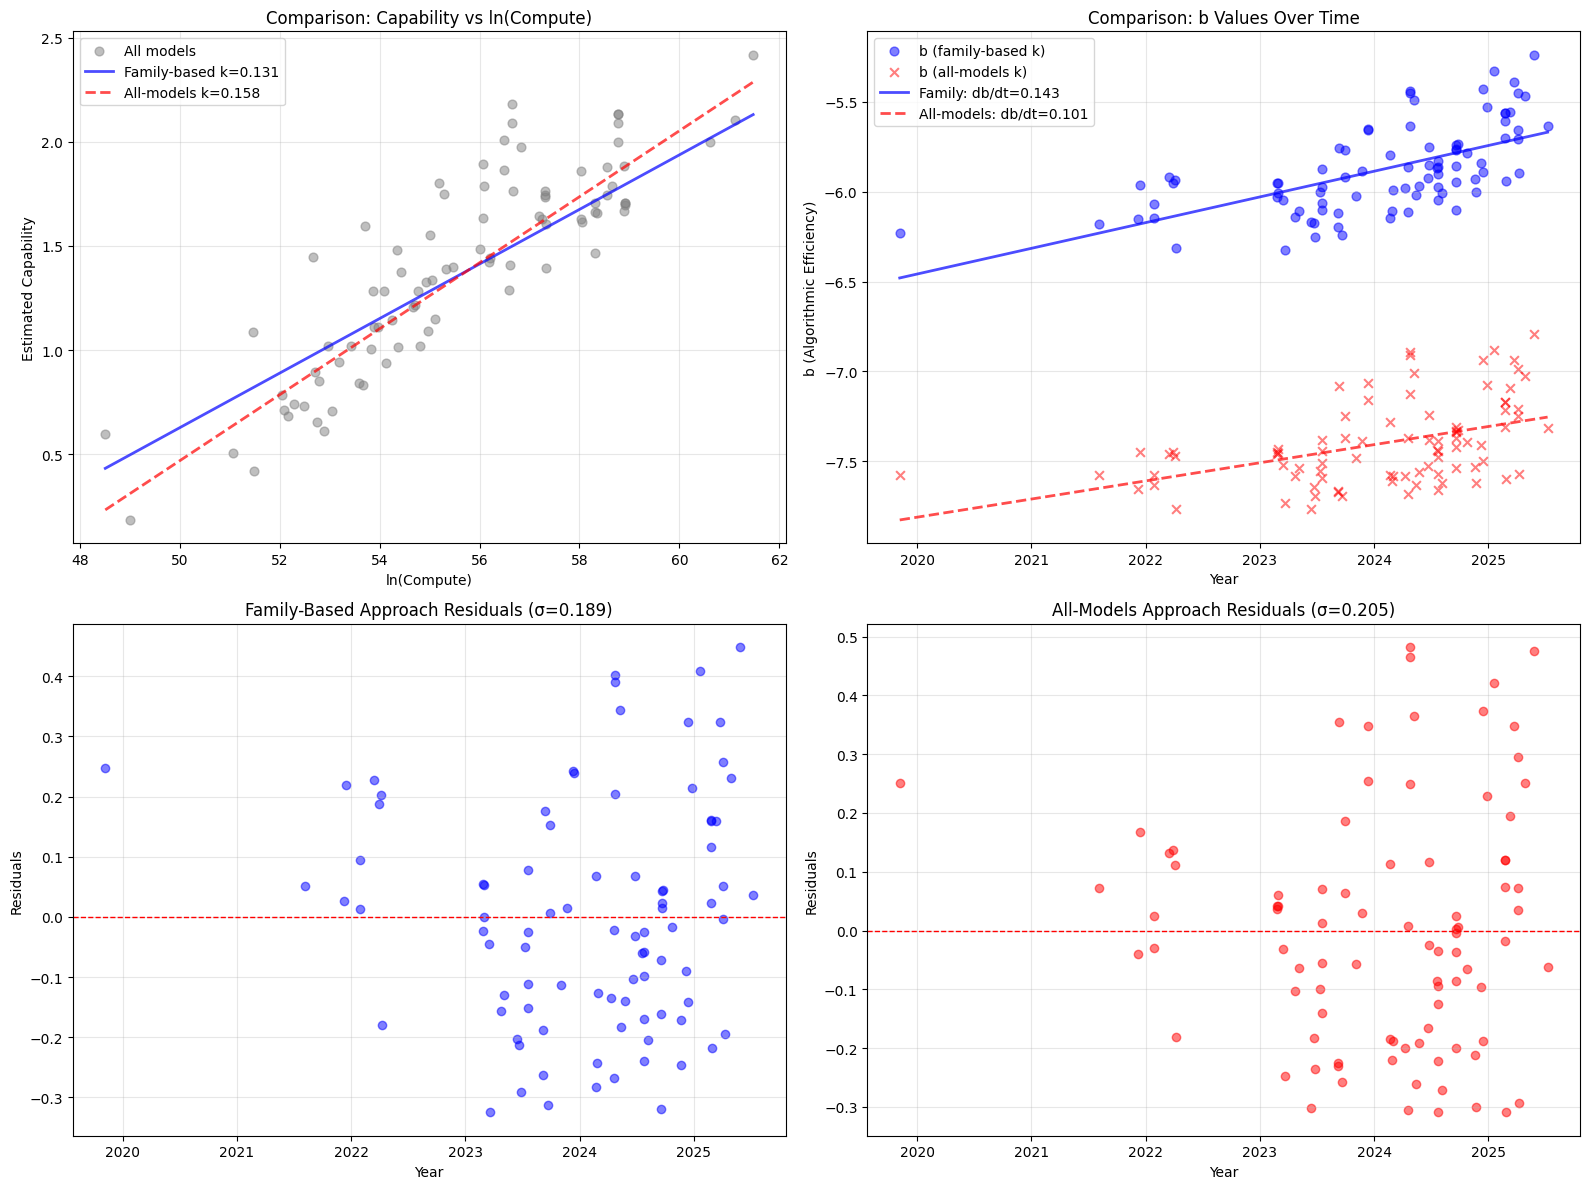


SUMMARY

Both approaches decompose capability growth into:
  • Compute scaling (k): How much capability increases per ln(compute)
  • Algorithmic progress (db/dt): How much algorithms improve per year

Key differences:
  • Family-based: Estimates k within families, averages across families
  • All-models: Pools all models together to estimate k

⚠ k estimates differ by >10%, suggesting families may have different scaling
⚠ db/dt estimates differ significantly, results may be sensitive to methodology


In [14]:
print("=" * 70)
print("COMPARISON: Family-Based vs All-Models Approach")
print("=" * 70)

print(f"\nCompute Scaling Coefficient (k):")
print(f"  Family-based (weighted avg): {k_fixed:.4f}")
print(f"  All-models fit:              {k_all_models:.4f}")
print(f"  Difference:                  {abs(k_fixed - k_all_models):.4f} ({abs(k_fixed - k_all_models)/k_fixed*100:.1f}%)")

print(f"\nAlgorithmic Progress Rate (db/dt):")
print(f"  Family-based approach: {b_slope:.4f} ± {b_std_err:.4f} per year")
print(f"  All-models approach:   {b_slope_alt:.4f} ± {b_std_err_alt:.4f} per year")
print(f"  Difference:            {abs(b_slope - b_slope_alt):.4f}")

print(f"\nEfficiency Improvement:")
print(f"  Family-based: {efficiency_improvement_per_year:.2f}× per year")
print(f"  All-models:   {efficiency_improvement_per_year_alt:.2f}× per year")

print(f"\nModel Fit Quality (R² for temporal trend):")
print(f"  Family-based: {b_r_value**2:.4f}")
print(f"  All-models:   {b_r_value_alt**2:.4f}")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Capabilities vs log(compute) - comparing both fits
ax1 = axes[0, 0]

# Plot all data points
ax1.scatter(all_models_with_compute['log_compute'], 
           all_models_with_compute['estimated_capability'],
           alpha=0.5, s=40, c='gray', label='All models')

# Add both trend lines
log_compute_range = np.linspace(
    all_models_with_compute['log_compute'].min(),
    all_models_with_compute['log_compute'].max(),
    100
)

# Family-based k line (using median b)
median_b_family = all_models_with_compute['b'].median()
capability_line_family = k_fixed * log_compute_range + median_b_family
ax1.plot(log_compute_range, capability_line_family, 'b-', linewidth=2, 
        alpha=0.7, label=f'Family-based k={k_fixed:.3f}')

# All-models k line
median_b_all = all_models_compute_alt['b'].median()
capability_line_all = k_all_models * log_compute_range + median_b_all
ax1.plot(log_compute_range, capability_line_all, 'r--', linewidth=2, 
        alpha=0.7, label=f'All-models k={k_all_models:.3f}')

ax1.set_xlabel('ln(Compute)')
ax1.set_ylabel('Estimated Capability')
ax1.set_title('Comparison: Capability vs ln(Compute)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: b values over time - both approaches
ax2 = axes[0, 1]

# Family-based b values
ax2.scatter(all_models_with_compute['date_numeric'], 
           all_models_with_compute['b'],
           alpha=0.5, s=40, color='blue', label='b (family-based k)')

# All-models b values
ax2.scatter(all_models_compute_alt['date_numeric'], 
           all_models_compute_alt['b'],
           alpha=0.5, s=40, color='red', marker='x', label='b (all-models k)')

# Add temporal trend lines
time_range = np.linspace(
    min(all_models_with_compute['date_numeric'].min(), all_models_compute_alt['date_numeric'].min()),
    max(all_models_with_compute['date_numeric'].max(), all_models_compute_alt['date_numeric'].max()),
    100
)

# Family-based trend
b_trend_family = b_slope * time_range + b_intercept
ax2.plot(time_range, b_trend_family, 'b-', linewidth=2, alpha=0.7,
        label=f'Family: db/dt={b_slope:.3f}')

# All-models trend
b_trend_all_comp = b_slope_alt * time_range + b_intercept_alt
ax2.plot(time_range, b_trend_all_comp, 'r--', linewidth=2, alpha=0.7,
        label=f'All-models: db/dt={b_slope_alt:.3f}')

ax2.set_xlabel('Year')
ax2.set_ylabel('b (Algorithmic Efficiency)')
ax2.set_title('Comparison: b Values Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals comparison - Family-based
ax3 = axes[1, 0]
predicted_b_family = b_slope * all_models_with_compute['date_numeric'] + b_intercept
residuals_family = all_models_with_compute['b'] - predicted_b_family

ax3.scatter(all_models_with_compute['date_numeric'], residuals_family, alpha=0.5, color='blue')
ax3.axhline(0, color='red', linestyle='--', linewidth=1)
ax3.set_xlabel('Year')
ax3.set_ylabel('Residuals')
ax3.set_title(f'Family-Based Approach Residuals (σ={np.std(residuals_family):.3f})')
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals comparison - All-models
ax4 = axes[1, 1]
predicted_b_all_comp = b_slope_alt * all_models_compute_alt['date_numeric'] + b_intercept_alt
residuals_all_comp = all_models_compute_alt['b'] - predicted_b_all_comp

ax4.scatter(all_models_compute_alt['date_numeric'], residuals_all_comp, alpha=0.5, color='red')
ax4.axhline(0, color='red', linestyle='--', linewidth=1)
ax4.set_xlabel('Year')
ax4.set_ylabel('Residuals')
ax4.set_title(f'All-Models Approach Residuals (σ={np.std(residuals_all_comp):.3f})')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

print(f"\nBoth approaches decompose capability growth into:")
print(f"  • Compute scaling (k): How much capability increases per ln(compute)")
print(f"  • Algorithmic progress (db/dt): How much algorithms improve per year")

print(f"\nKey differences:")
print(f"  • Family-based: Estimates k within families, averages across families")
print(f"  • All-models: Pools all models together to estimate k")

if abs(k_fixed - k_all_models) / k_fixed < 0.1:
    print(f"\n✓ k estimates are similar (within 10%), suggesting robust scaling law")
else:
    print(f"\n⚠ k estimates differ by >10%, suggesting families may have different scaling")

if abs(b_slope - b_slope_alt) / max(abs(b_slope), abs(b_slope_alt)) < 0.2:
    print(f"✓ db/dt estimates are similar (within 20%), suggesting robust algorithmic progress estimate")
else:
    print(f"⚠ db/dt estimates differ significantly, results may be sensitive to methodology")
